In this notebook, we tried a sample of Nylon in a solution that had 250g sugar for 2L water

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import nibabel as nib
import cv2
from sklearn.linear_model import LinearRegression 
import scipy
import scipy.io
from skimage.transform import rescale as resc
from skimage.transform import downscale_local_mean
import plotly.graph_objects as go
from scipy.io import savemat
from scipy.ndimage import gaussian_filter

import tqdm

In [3]:
### parameters and constants
TE1=3.06*0.001 #s
TE2=4.08*0.001 #s
delta_TE=TE2-TE1
gamma = 2.675221900e8 # /s/T

# I.  Field maps 

In [4]:
def mask(path_mag1, material, tresh, plot=True, slice=71):
'''
    Return a mask with 0 if inside the compound and 1 outside

    Parameters
    ----------
    path_mag1 : str
        path to the magnitude 1 of the compound.
    material : str
        description of the compound.
    tresh : float
        magnitude treshold of the mask.
    plot : bool, optional
        if true, plot a slice of the magnitude and of the mask. The default is True.
    slice : int, optional
        the slice to plot. The default is 71.

    Returns
    -------
    mask : numpy.ndarray
        mask of the compound.

    '''
    ######## magnitude #############
    mag1 = nib.load(path_mag1)
    data_mag1=mag1.get_fdata() #extract matrix with values
    
    mask = data_mag1 > tresh #return array of booleens
    
    
    #plot the selected slice 
    if plot==True:
        plt.figure(figsize=(8,5))
        plt.subplot(1,2,1)
        plt.imshow(data_mag1[:,:,slice])
        plt.colorbar()
        plt.title(f'Magnitude_1 of {material}')
    
        plt.subplot(1,2,2)
        plt.imshow(mask[:, :, slice])
        plt.colorbar()
        plt.title(f'mask of {material}')
    
        plt.tight_layout()
    return mask

In [5]:
def rescale(path_mag1, path_phase, material, deltaTE=delta_TE, slice=80, masking=True, seuil=400):
    '''
    Rescale the acquired phase difference to a field map in Hz.
    
    Rescale from the phase difference in 2^13 bits to a field map in Hz, and plot the magnitude, phase difference and field map.
    If masking = True then put values inside the compound at zero.


    Parameters
    ----------
    path_mag1 : str
        path to the first magnitude.
    path_phase : str
        path to the phase difference.
    material : str
        description of the compound.
    deltaTE : float
        TE2-TE1.
    slice : int, optional
        Slice to plot. The default is 80.
    masking : bool, optional
        apply the mask of the magnitude to the field map. The default is True.

    Returns
    -------
    data_phase : numpy.ndarray
        rescaled field map in Hz.

    '''
    ######## magnitude #############
    data_mag1=nib.load(path_mag1).get_fdata() #extract matrix with values of magnitude 1
    
    #plot the selected slice of the magnitude
    plt.figure('f{material}', figsize=(10,4))
    plt.subplot(1,2,1)
    plt.imshow(data_mag1[:,:,slice])
    plt.colorbar()
    plt.title(f'Magnitude_1 of {material}')
    
    
    ########### phase difference and field map ############
    data_phase = nib.load(path_phase).get_fdata() #extract matrix with values
    
    #rescaling:a
    data_phase *= np.pi/4096 #set the phase between -pi and pi
    data_phase /= (deltaTE*2*np.pi) #in Hz
    #data_phase /= gamma # in T
    
    # apply the mask if needed
    if masking==True:
        maske=mask(path_mag1, material, seuil, plot=False, slice=slice)
        data_phase *= maske
    
    
    #plot the selected slice of field map
    plt.subplot(1,2,2)
    plt.imshow(data_phase[:,:,slice])
    plt.colorbar()
    plt.title(f'Field map (Hz) of {material}')
    plt.show()
    
    plt.tight_layout()
    
    return data_phase 

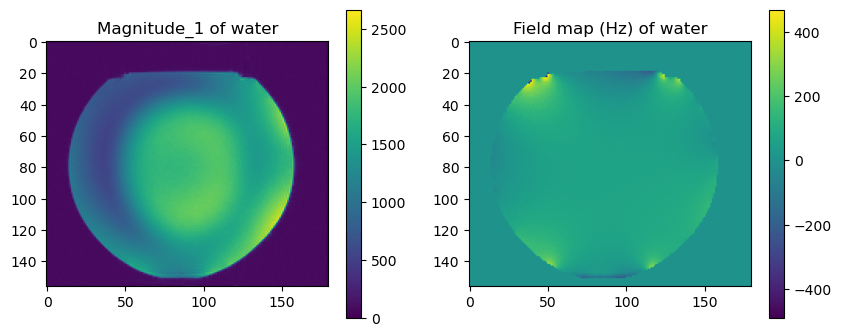

<Figure size 640x480 with 0 Axes>

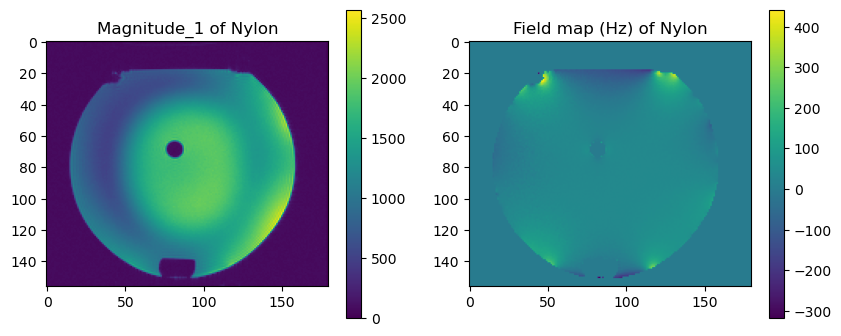

<Figure size 640x480 with 0 Axes>

In [6]:
# external solution = 150g sugar for 2L water + (25ml soap + salt)in 1.6L
path_mag1_water = r"FM_1_0MM_WATERSUGARREF_0004\FM_1_0MM_WATERSUGARREF_0004_fm_1.0mm_waterSugarRef_20230327150132_4_e1.nii.gz"
path_phase_water = r"FM_1_0MM_WATERSUGARREF_0005\FM_1_0MM_WATERSUGARREF_0005_fm_1.0mm_waterSugarRef_20230327150132_5_e2_ph.nii.gz"
delta_B_water = rescale(path_mag1_water, path_phase_water, "water", delta_TE, masking=True, seuil=300)

#external solution + nylon
path_mag1_nylon = r"FM_1_0MM_NYLON_WATERSUGAR_0006\FM_1_0MM_NYLON_WATERSUGAR_0006_fm_1.0mm_nylon_waterSugar_20230327150132_6_e1.nii.gz"
path_phase_nylon = r"FM_1_0MM_NYLON_WATERSUGAR_0007\FM_1_0MM_NYLON_WATERSUGAR_0007_fm_1.0mm_nylon_waterSugar_20230327150132_7_e2_ph.nii.gz"
delta_B_nylon = rescale(path_mag1_nylon, path_phase_nylon, "Nylon", delta_TE, masking=True, seuil=350)



In [7]:
##############################################################################""""""

x_nylon, y_nylon, z_nylon = 81,68,75
dx, dy, dz = 12,12,12
#################################################################################


(156, 180, 160)


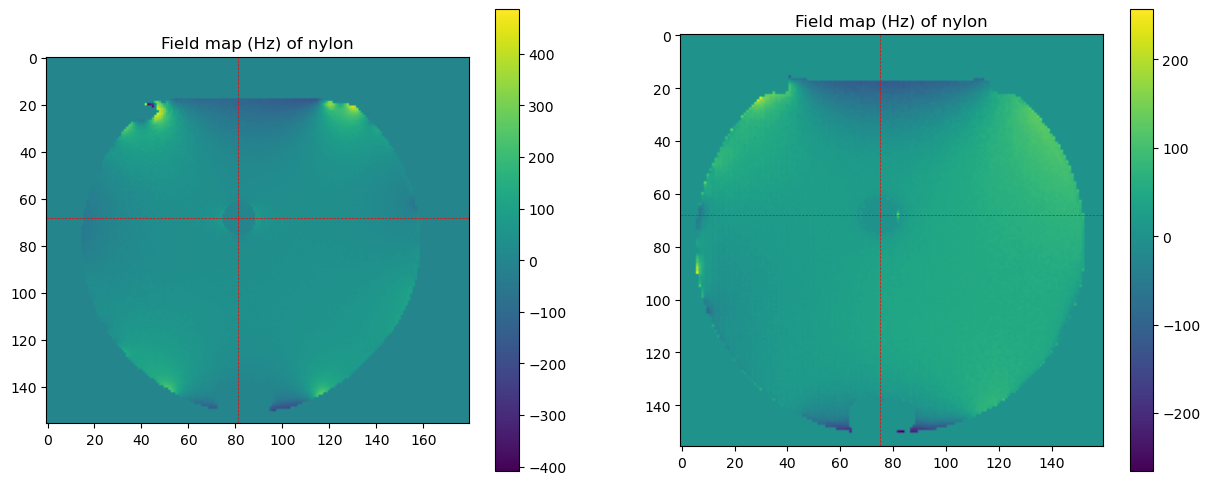

In [8]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.imshow(delta_B_nylon[:,:,z_nylon])
plt.colorbar()
plt.axvline(x=x_nylon,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.axhline(y=y_nylon,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.title(f'Field map (Hz) of nylon')

plt.subplot(1,2,2)
plt.imshow(delta_B_nylon[:,x_nylon,:])
plt.colorbar()
plt.axvline(x=z_nylon,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.axhline(y=y_nylon,color='r',linestyle='--', linewidth=0.5) #to find the center of the ball
plt.title(f'Field map (Hz) of nylon')

print(np.shape(delta_B_nylon))

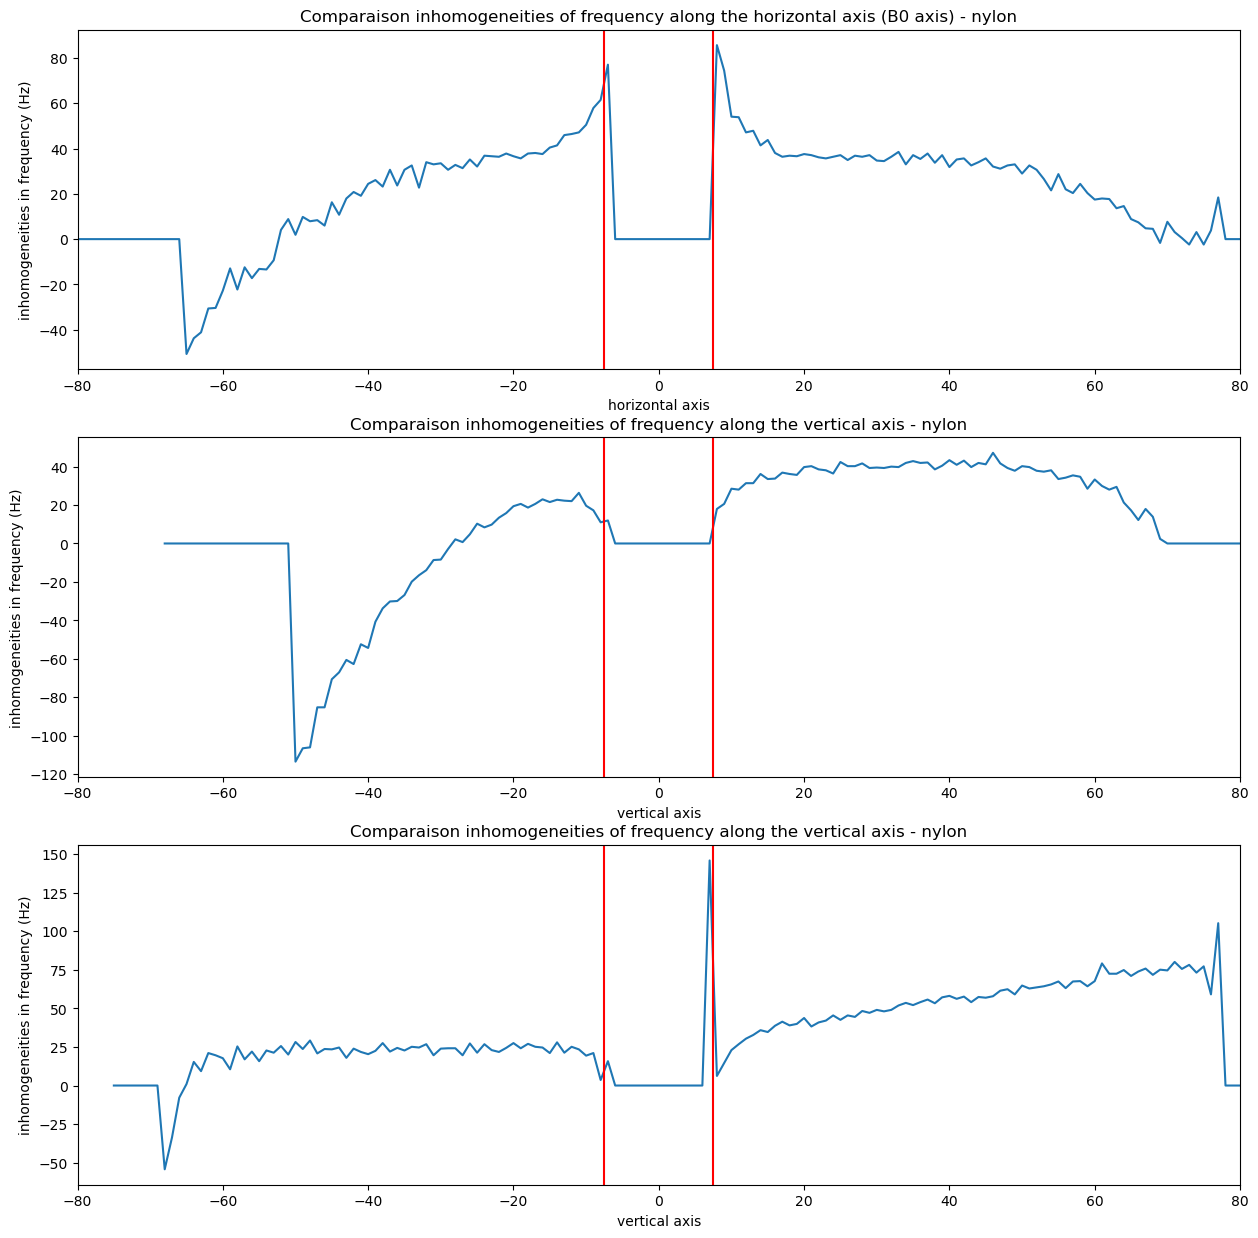

<Figure size 640x480 with 0 Axes>

In [9]:
##### plot lineplot axe horizontal
freq_nylon_x = (delta_B_nylon[y_nylon, :, z_nylon])

abscisse_nylon_x = [i-x_nylon for i in range(180)] #recenter the ball at zero

plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.plot(abscisse_nylon_x, freq_nylon_x)
plt.title('Comparaison inhomogeneities of frequency along the horizontal axis (B0 axis) - nylon')
plt.xlabel('horizontal axis')
plt.ylabel('inhomogeneities in frequency (Hz)')
plt.xlim(-80,80)
plt.axvline(x=7.5, c='r')
plt.axvline(x=-7.5, c='r')



##### plot lineplot axe vertical
freq_nylon_y = (delta_B_nylon[:, x_nylon, z_nylon])

abscisse_nylon_y = [i-y_nylon for i in range(np.shape(delta_B_nylon)[0])] #recenter the ball at zero


plt.subplot(3,1,2)
plt.plot(abscisse_nylon_y, freq_nylon_y, label='nylon')
plt.title('Comparaison inhomogeneities of frequency along the vertical axis - nylon')
plt.xlabel('vertical axis')
plt.ylabel('inhomogeneities in frequency (Hz)')
plt.xlim(-80,80)
plt.axvline(x=7.5, c='r')
plt.axvline(x=-7.5, c='r')


##### plot lineplot axe profondeur
freq_nylon_z = (delta_B_nylon[y_nylon, x_nylon, :])

abscisse_nylon_z = [i-z_nylon for i in range(np.shape(delta_B_nylon)[2])] #recenter the ball at zer

plt.subplot(3,1,3)
plt.plot(abscisse_nylon_z, freq_nylon_z, label='nylon')
plt.title('Comparaison inhomogeneities of frequency along the vertical axis - nylon')
plt.xlabel('vertical axis')
plt.ylabel('inhomogeneities in frequency (Hz)')
plt.axvline(x=7.5, c='r')
plt.axvline(x=-7.5, c='r')

plt.xlim(-80,80)

plt.show()
plt.tight_layout()

Correction: 

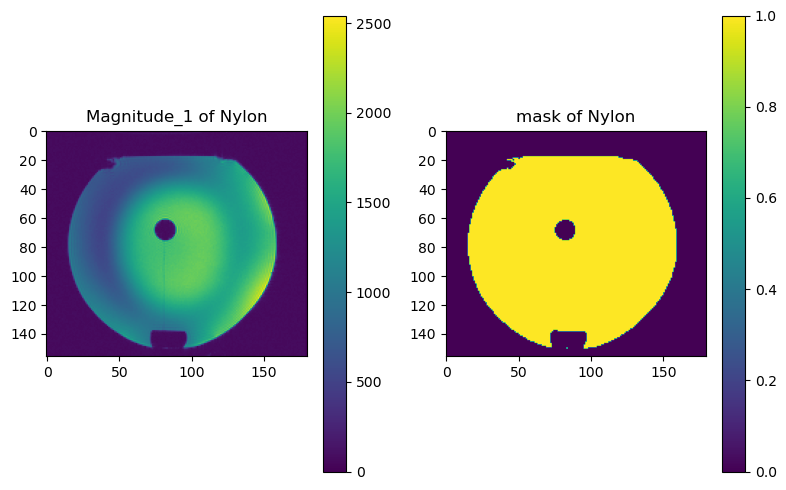

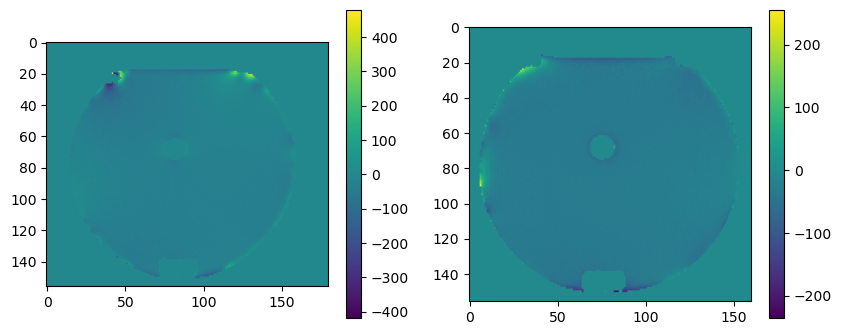

In [10]:
fm_nylon = (delta_B_nylon - gaussian_filter(delta_B_water, sigma=2))*mask(path_mag1_nylon, 'Nylon', tresh=300, plot=True, slice=z_nylon)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(fm_nylon[:,:,z_nylon])
plt.colorbar()
plt.subplot(122)
plt.imshow(fm_nylon[:,x_nylon,:])
plt.colorbar()

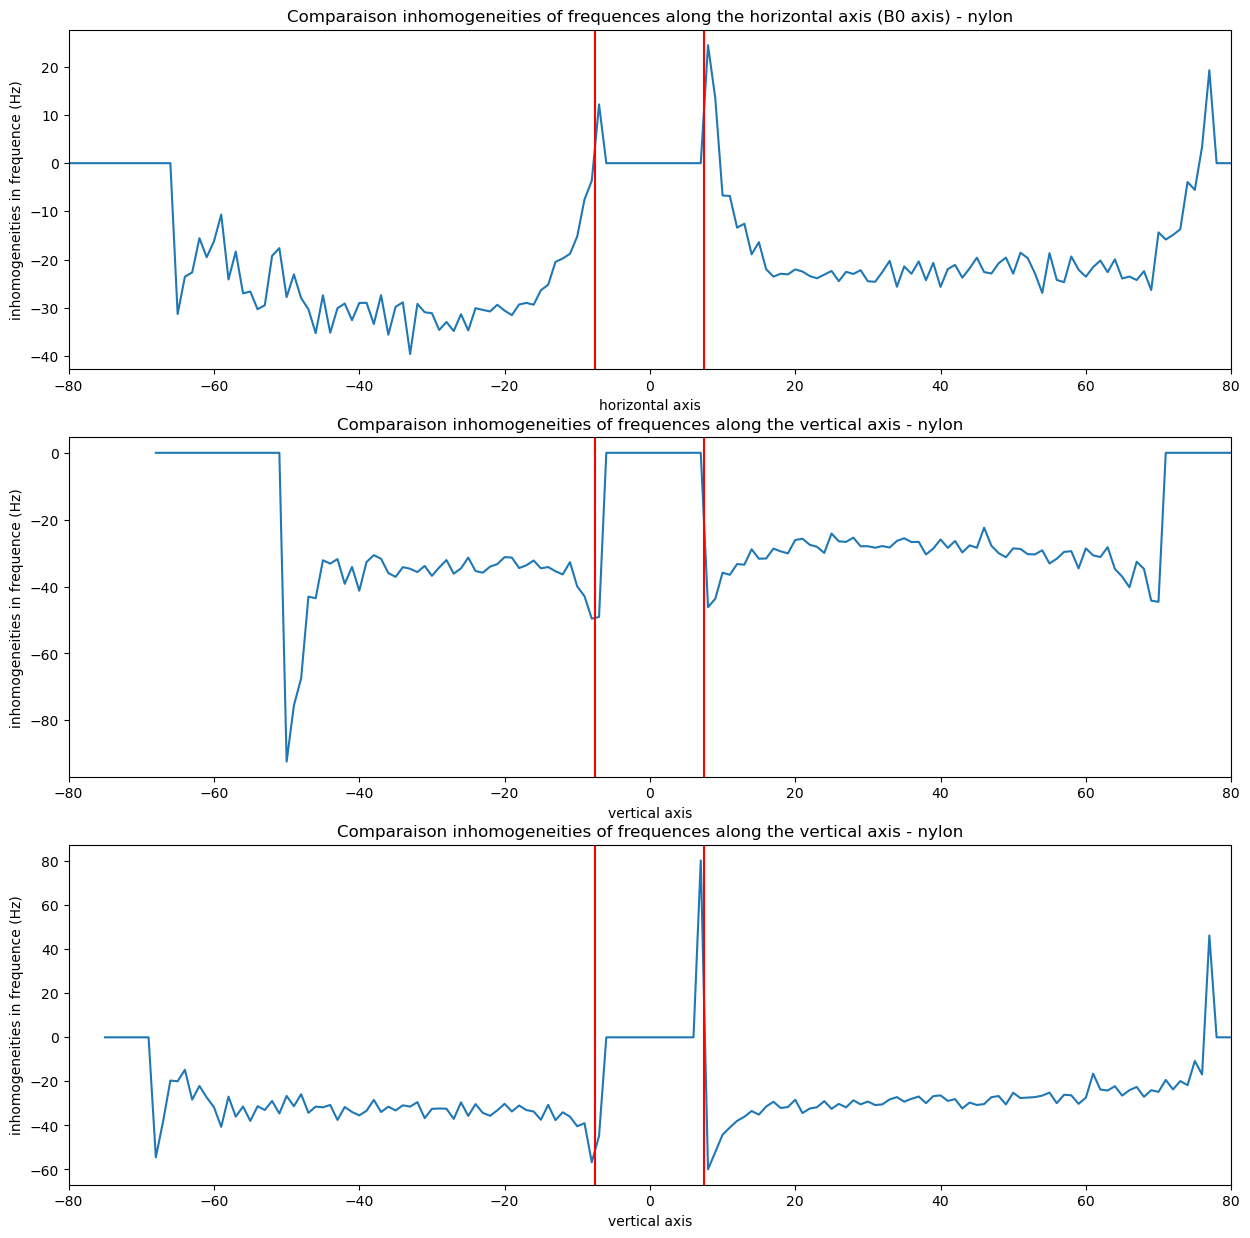

<Figure size 640x480 with 0 Axes>

In [11]:
##### plot lineplot axe horizontal
freq_nylon_x = (fm_nylon[y_nylon, :, z_nylon])

abscisse_nylon_x = [i-x_nylon for i in range(180)] #recenter the ball at zero

plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.plot(abscisse_nylon_x, freq_nylon_x)
plt.title('Comparaison inhomogeneities of frequences along the horizontal axis (B0 axis) - nylon')
plt.xlabel('horizontal axis')
plt.ylabel('inhomogeneities in frequence (Hz)')
plt.xlim(-80,80)
plt.axvline(x=7.5, c='r')
plt.axvline(x=-7.5, c='r')



##### plot lineplot axe vertical
freq_nylon_y = (fm_nylon[:, x_nylon, z_nylon])

abscisse_nylon_y = [i-y_nylon for i in range(np.shape(delta_B_nylon)[0])] #recenter the ball at zero


plt.subplot(3,1,2)
plt.plot(abscisse_nylon_y, freq_nylon_y, label='nylon')
plt.title('Comparaison inhomogeneities of frequences along the vertical axis - nylon')
plt.xlabel('vertical axis')
plt.ylabel('inhomogeneities in frequence (Hz)')
plt.xlim(-80,80)
plt.axvline(x=7.5, c='r')
plt.axvline(x=-7.5, c='r')


##### plot lineplot axe profondeur
freq_nylon_z = (fm_nylon[y_nylon, x_nylon, :])

abscisse_nylon_z = [i-z_nylon for i in range(np.shape(delta_B_nylon)[2])] #recenter the ball at zer

plt.subplot(3,1,3)
plt.plot(abscisse_nylon_z, freq_nylon_z, label='nylon')
plt.title('Comparaison inhomogeneities of frequences along the vertical axis - nylon')
plt.xlabel('vertical axis')
plt.ylabel('inhomogeneities in frequence (Hz)')
plt.axvline(x=7.5, c='r')
plt.axvline(x=-7.5, c='r')

plt.xlim(-80,80)

plt.show()
plt.tight_layout()

In [12]:
def rescaling_FOV(field_map, x, y, z, dx=dx, dy=dy, dz=dz):
    '''
    Reshape field_map to a smaller array

    Create a new smaller matrix of volume 2dx*2dy*2dz with values recentered on x,y,z
    Attention: x is the second component and y the first one.

    Parameters
    ----------
    field_map : numpy.ndarray
        3D array pf the FM to reshape.
    x : int
        x coordinate around which field_map will be reshaped
    y : int
        y coordinate around which field_map will be reshaped
    z : int
        z coordinate around which field_map will be reshaped
    dx : int, optional
        0.5*width along the x direction of the reshaped matrix. The default is dx.
    dy : int, optional
        0.5*width along the y direction of the reshaped matrix. The default is dy.
    dz : int, optional
        0.5*width along the z direction of the reshaped matrix. The default is dz.
            
    Returns
    -------
    rescaled_matrix : numpy.ndarray
        Reshaped 3D array.

    '''
    rescaled_matrix= field_map[y-dy:y+dy+1, x-dx:x+dx+1, z-dz: z+dz+1] 
   
    return rescaled_matrix

The average background of the fm of the smoothed nylon, backgound corrected, is -30.530130314066646


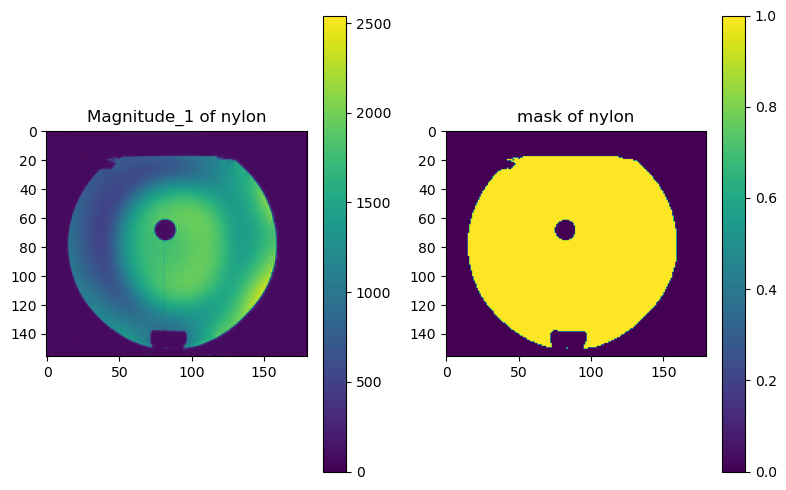

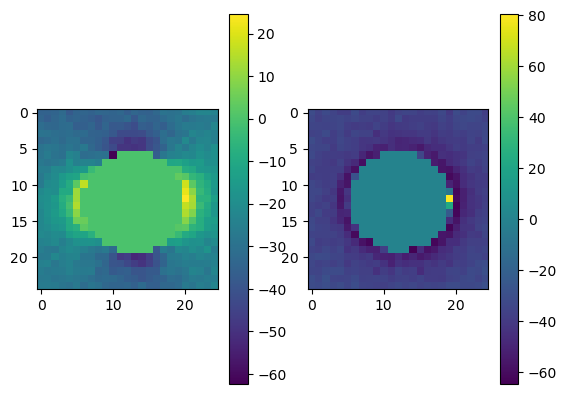

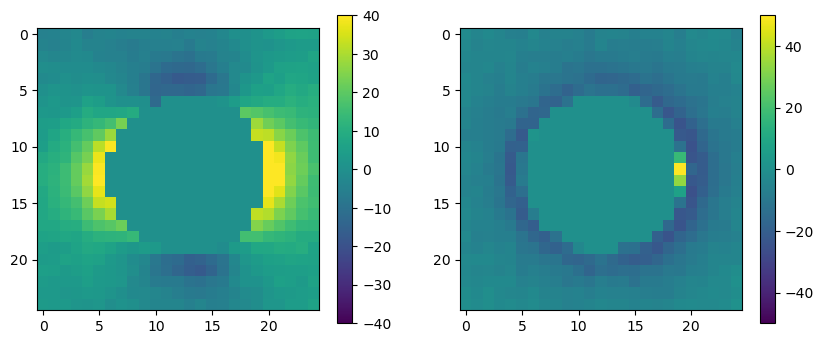

In [13]:
mask_nylon = rescaling_FOV(mask(path_mag1_nylon, 'nylon', tresh=300, plot=True, slice=z_nylon), x=x_nylon, y=y_nylon, z=z_nylon)


fm_exp_nylon_final_presque = rescaling_FOV(fm_nylon, x_nylon, y_nylon, z_nylon)
plt.figure()
plt.subplot(121)
plt.imshow(fm_exp_nylon_final_presque[:,:,dz])
plt.colorbar()
plt.subplot(122)
plt.imshow(fm_exp_nylon_final_presque[:,dx,:])
plt.colorbar()


##########################################################33
fm_exp_nylon_final_presque_presque  = gaussian_filter(fm_exp_nylon_final_presque, sigma=0.5) #smooth a bit the field map

avg_backg_nylon = np.average(fm_exp_nylon_final_presque_presque, weights = mask_nylon)
print(f'The average background of the fm of the smoothed nylon, backgound corrected, is {avg_backg_nylon}')
fm_exp_nylon_final = (fm_exp_nylon_final_presque_presque - avg_backg_nylon)*mask_nylon

####################################################3
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(fm_exp_nylon_final[:,:,dz], vmin=-40, vmax=40)
plt.colorbar()
plt.subplot(122)
plt.imshow(fm_exp_nylon_final[:,dx,:], vmin=-50, vmax=50)
plt.colorbar()

### B. Simulations

In [14]:
### save and export the masks in matlab format to run the simulation on them
mdic = {"mask_nylon": mask_nylon, "label": "mask_nylon"}
# savemat("mask_nylon.mat", mdic)

In [15]:
simu_mask_nylon_final = -(scipy.io.loadmat(r"I_mask_nylon_simu.mat")['I'][137:162,137:162,137:162]-1)
simu_nylon_final = scipy.io.loadmat(r"i_sus_simu_nylon.mat")['I_sus'][137:162,137:162,137:162].real * simu_mask_nylon_final

print(np.shape(simu_nylon_final))
print(np.shape(simu_mask_nylon_final))



(25, 25, 25)
(25, 25, 25)


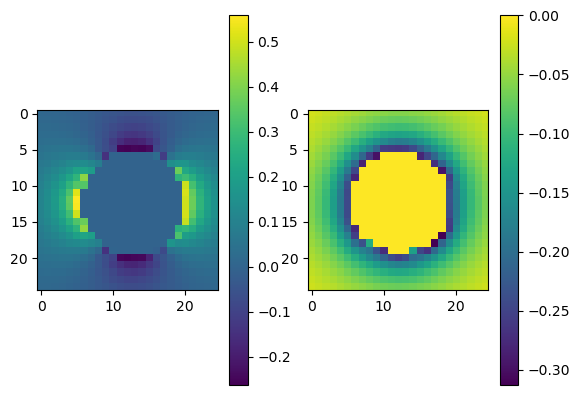

In [16]:
plt.figure()
plt.subplot(121)
plt.imshow(simu_nylon_final[:,:,dz])
plt.colorbar()
plt.subplot(122)
plt.imshow(simu_nylon_final[:,dx,:])
plt.colorbar()

Check the superposition

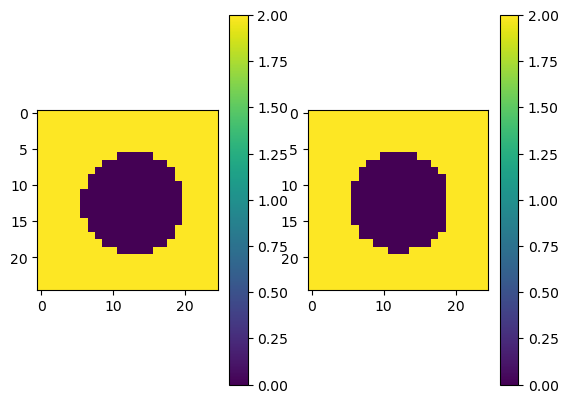

In [17]:
plt.figure()
plt.subplot(121)
plt.imshow((mask_nylon+simu_mask_nylon_final)[:,:,dz])
plt.colorbar()
plt.subplot(122)
plt.imshow((mask_nylon+simu_mask_nylon_final)[:,dx,:])
plt.colorbar()

In [18]:
def linear_reg_simexp(fm_simu1, fm_exp1, mask_simu1, mask_exp1, part, xmin=0, ymin=0, zmin=0, xmax=np.shape(simu_nylon_final)[1], ymax=np.shape(simu_nylon_final)[0], zmax=np.shape(simu_nylon_final)[2], vmin=-30, vmax=30):
    '''
    Calculate the linear regression between `fm_simu1` and `fm_exp1`, excluding the values inside the masks (inside the compound).

    
    The regression between fm_simu1 and fm_exp1 is calculated on the voxels which coordinates are inside [xmin,xmax],[ymin,ymax],[zmin,zmax]
    Attention: x is the second component and y the first one.
    Plot the linear regression, one slice of the simulated and acquired field map and the histogram of the error. 
    
    Parameters
    ----------
    fm_simu1 : np.ndarray
        3D array of the simulated FM.
    fm_exp1 : np.ndarray
        3D array of the acquired FM.
    mask_simu1 : np.ndarray
        3D array of the simulated mask.
    mask_exp1 : np.ndarray
        3D array of the acquired mask.
    part : str
        description of the compound.
    xmin : int, optional
        the minimum x value to use for the regression calculation. The default is 0.
    ymin : int, optional
        the minimum y value to use for the regression calculation. The default is 0.
    zmin : int, optional
        the minimum z value to use for the regression calculation. The default is 0.
    xmax : int, optional
        the maximum x value to use for the regression calculation. The default is np.shape(simu_nylon_final)[1].
    ymax : int, optional
        the maximum y value to use for the regression calculation. The default is nnp.shape(simu_nylon_final)[0].
    zmax : int, optional
        the maximum z value to use for the regression calculation. The default is np.shape(simu_nylon_final)[2].

    Returns
    -------
    result_corrected : scipy.stats._stats_mstats_common.LinregressResult
        A tuple containing the parameters of the regression line.

    '''
    ### reshaping to 1D vector
    
    fm_simu=fm_simu1[ymin:ymax, xmin:xmax, zmin:zmax]
    fm_exp=fm_exp1[ymin:ymax, xmin:xmax, zmin:zmax]
    mask_simu2=mask_simu1[ymin:ymax, xmin:xmax, zmin:zmax]
    mask_exp2=mask_exp1[ymin:ymax, xmin:xmax, zmin:zmax]

    m,n,p = fm_simu.shape
    simu = fm_simu.reshape(m*n*p) #need to have vector 1D to apply the linear regression
    exp = fm_exp.reshape(n*m*p)

    mask_exp = mask_exp2.reshape(m*n*p)
    mask_simu = mask_simu2.reshape(m*n*p)

    exp_corrected = []
    simu_corrected=[]

    for i in range(m*p*n):
        if mask_exp[i]!=0 and mask_simu[i]!=0:
            simu_corrected.append(simu[i])
            exp_corrected.append(exp[i])

    ### regression lineaire
    result_corrected = scipy.stats.linregress(simu_corrected, exp_corrected)
    print(f'######## regression linéaire - {part} ############')
    print(f' fm_exp = {result_corrected.slope} * fm_simu + {result_corrected.intercept} ')
    print(f'R^2 = {result_corrected.rvalue **2}')
    print(f'p-value = {result_corrected.pvalue }')


    #######################"" plot################################
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.plot(simu_corrected, exp_corrected, '.', c='pink', label=part)
    plt.xlabel('Simulation')
    plt.ylabel('Experience')
    plt.title(f'Correlation between simulation and experience on {part}')
    plt.plot(simu, result_corrected.intercept + result_corrected.slope*simu, 'b')
#     plt.legend()
    
    plt.subplot(122) #histogram of the error
    approx = np.array([result_corrected.intercept + result_corrected.slope*simu_corrected[i] for i in range(len(simu_corrected))])
    error = exp_corrected - approx #f(xi)-y
    plt.hist(error, bins=75)
    plt.title('Histogram of the error f(xi)-y')
    plt.tight_layout()
    plt.show()
    
    plt.figure()
    plt.subplot(2,2,1)
    plt.imshow(result_corrected.slope*fm_simu[:,int((xmax-xmin)/2), :], vmin=vmin, vmax=vmax)
    plt.title("simu corrected")
    plt.colorbar()
    plt.subplot(2,2,2)
    plt.imshow(result_corrected.slope*fm_simu[:,:, int((zmax-zmin)/2)],  vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.subplot(2,2,3)
    plt.title("measurements")
    plt.colorbar()
    plt.imshow(fm_exp[:,int((xmax-xmin)/2), :],  vmin=vmin, vmax=vmax)
    plt.subplot(2,2,4)
    plt.imshow(fm_exp[:,:, int((zmax-zmin)/2)],  vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    
    print(np.shape(fm_simu))
    return result_corrected

######## regression linéaire - whole array nylon ############
 fm_exp = 83.42083531858489 * fm_simu + 0.02288234184253488 
R^2 = 0.7664913388188817
p-value = 0.0


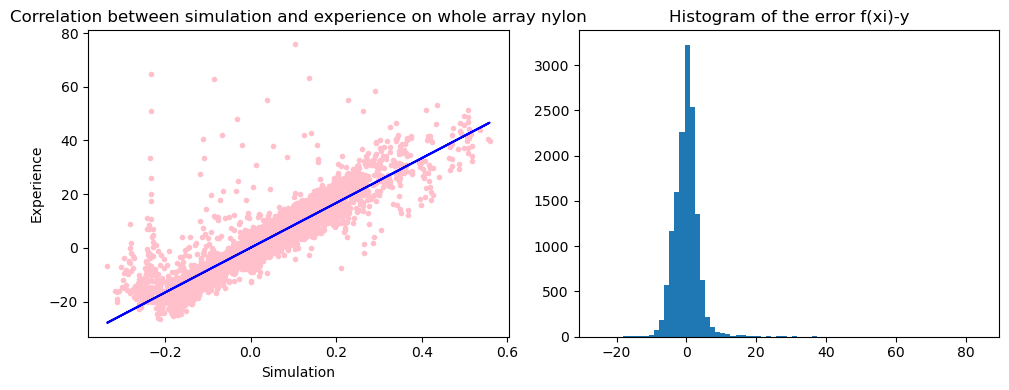

C:\Users\b\AppData\Local\Temp\ipykernel_17428\3503860450.py:64: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()


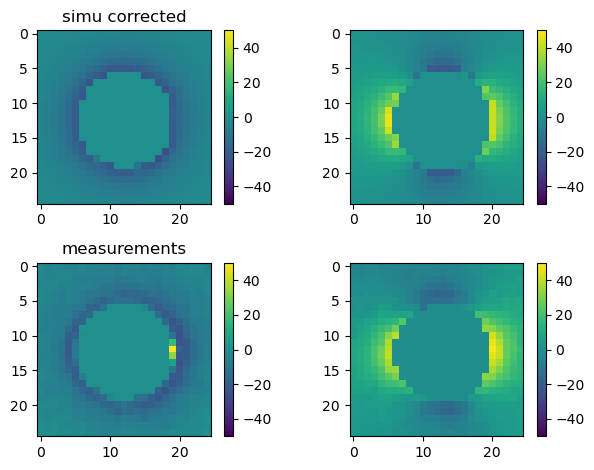

(25, 25, 25)


In [20]:
result_nylon = linear_reg_simexp(fm_simu1=simu_nylon_final, fm_exp1=fm_exp_nylon_final, mask_simu1=simu_mask_nylon_final, mask_exp1=mask_nylon, part="whole array nylon", xmin=0, ymin=0, zmin=0, xmax=np.shape(fm_exp_nylon_final)[1], ymax=np.shape(fm_exp_nylon_final)[0], zmax=np.shape(fm_exp_nylon_final)[2], vmin=-50, vmax=50)


# Multiecho GRE

In [21]:
path_12TE_nylon = [f"GRE_0_3MM_12TE_NYLON_WATERSUGAR_0009\GRE_0_3MM_12TE_NYLON_WATERSUGAR_0009_GRE_0.3mm_12TE_nylon_waterSugar_20230327150132_9_e{i}.nii.gz" for i in range(1,13) ]

(600, 576, 26)


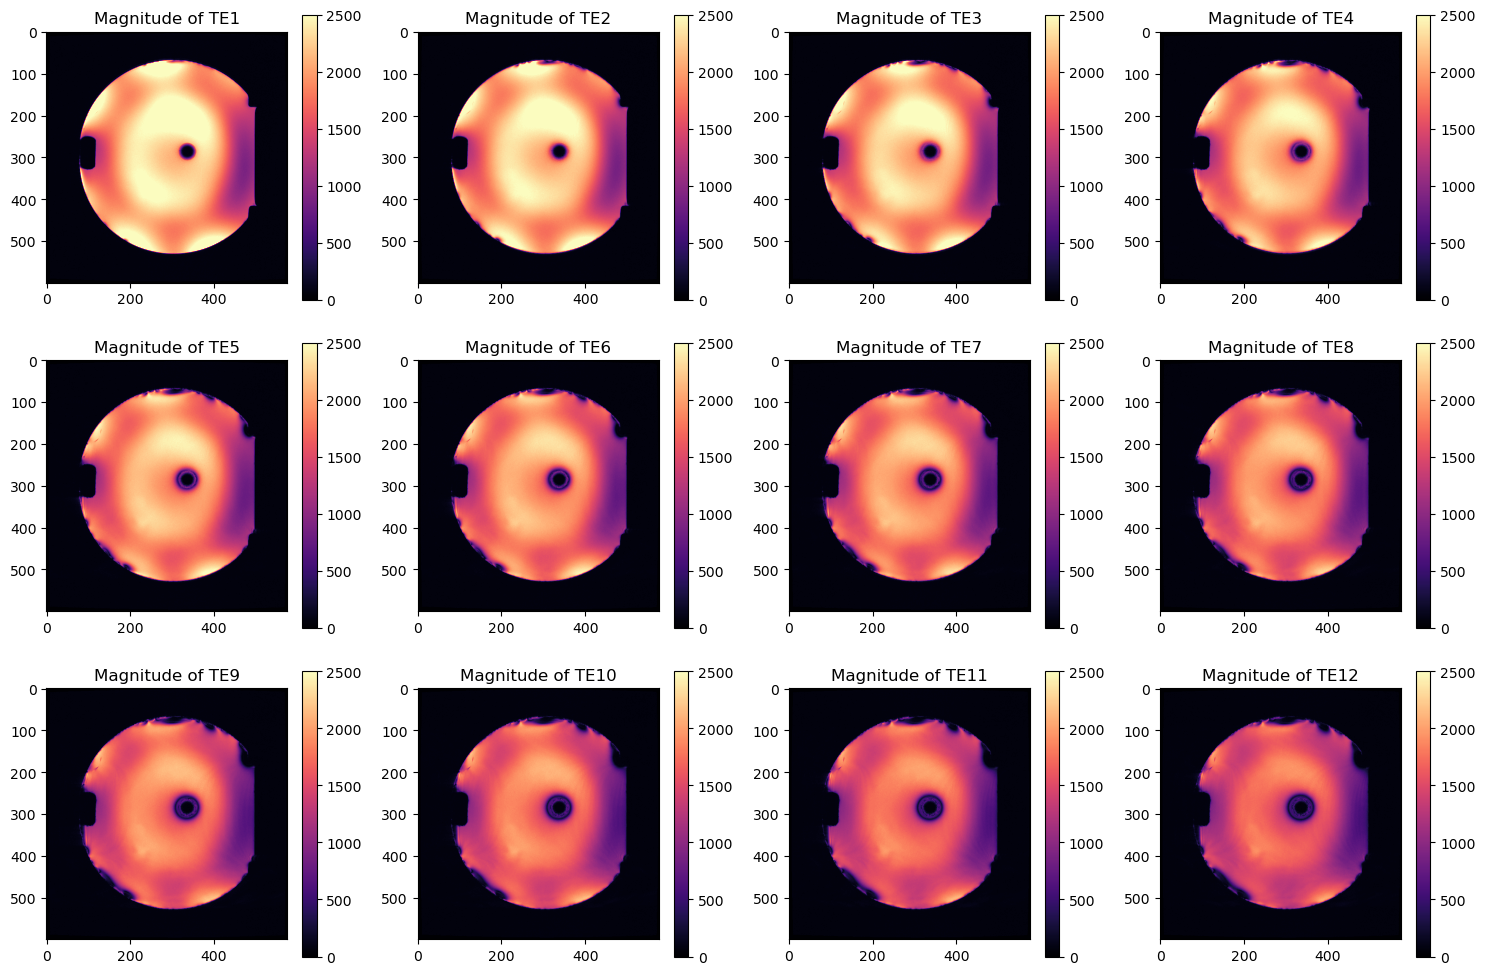

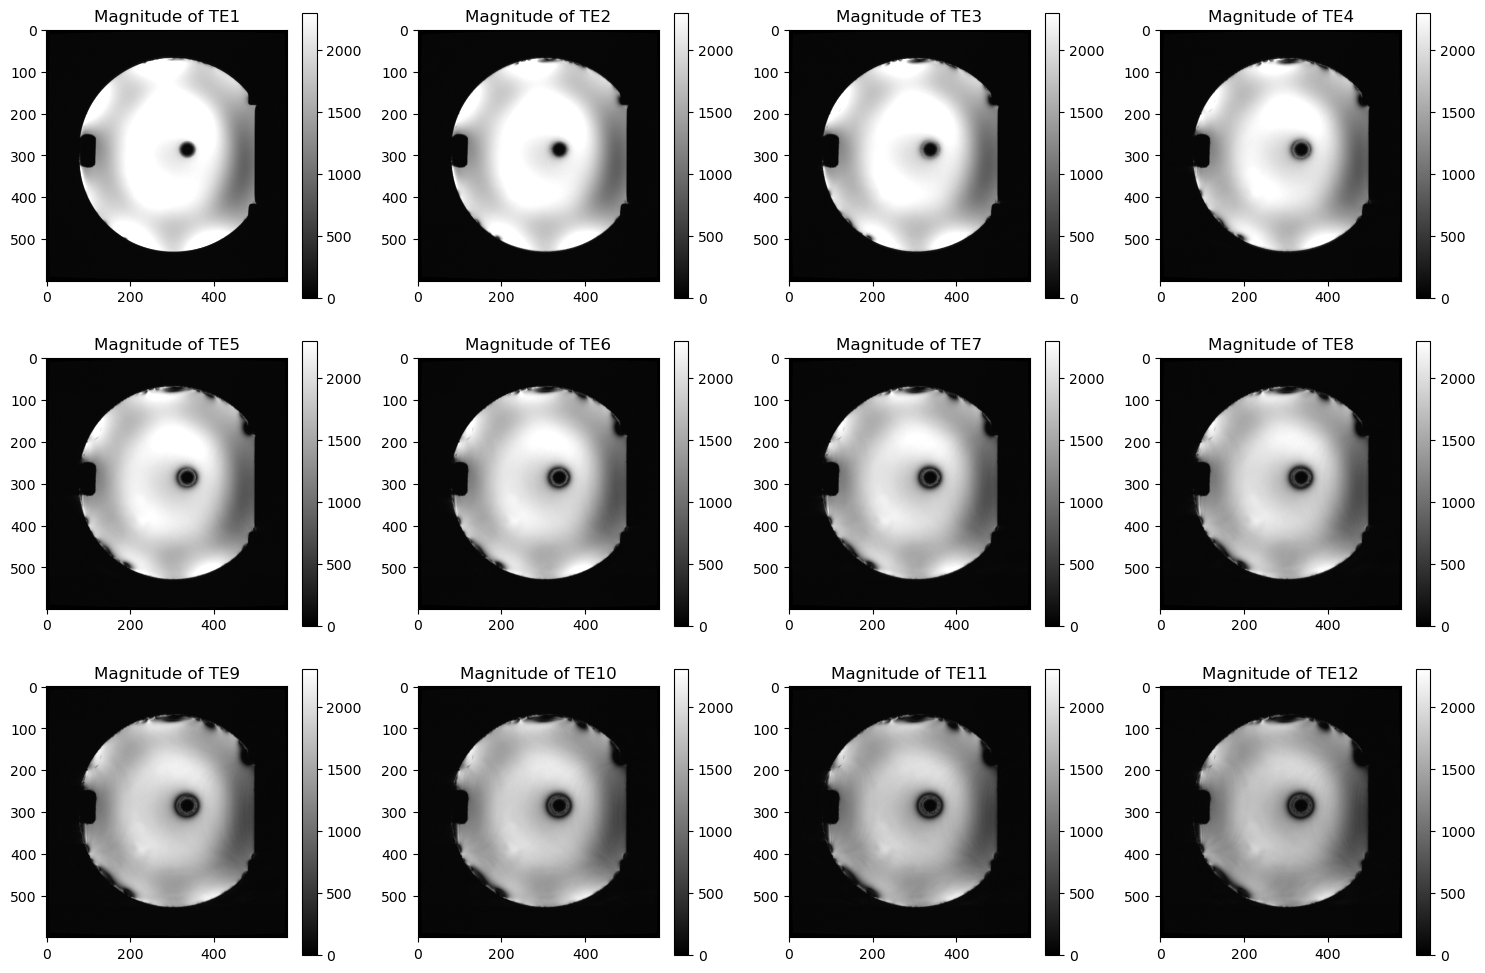

In [37]:
mag_12TE_nylon = [nib.load(path_12TE_nylon[i]).get_fdata() for i in range(12)]

plt.figure('12TE', figsize=(15,10))

for i in range(len(mag_12TE_nylon)):
    plt.subplot(3,4,i+1)
    plt.imshow(mag_12TE_nylon[i][:,:,12] , cmap='magma', vmax=2500)
    plt.colorbar()
    plt.title(f'Magnitude of TE{i+1}')

plt.tight_layout()

print(np.shape(mag_12TE_nylon[0]))
plt.show()

plt.figure('12TE', figsize=(15,10))

for i in range(len(mag_12TE_nylon)):
    plt.subplot(3,4,i+1)
    plt.imshow(mag_12TE_nylon[i][:,:,12] , cmap='gray', vmax=2300)
    plt.colorbar()
    plt.title(f'Magnitude of TE{i+1}')

plt.tight_layout()

In [26]:
def multiTE_plot(x, mag_multiTE , color='gray'):
    """
    Plot one transversal slice for the 12 different TE and their difference from the first image.

    Parameters
    ----------
    x : int
        x-coordinate of the slices to display
    mag_multiTE : list, optimal
        list of magnitude 3D arrays for each TE time. The default is mag_12TE.
    color : str, optional
        colormap to use for the images. The default is 'gray'.

    Returns
    -------
    None
        
    """
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))
    c=0
    for ax in axes.flat:
        mag_rescaled = rescaling_FOV(mag_multiTE[c], x=320, y=300, z=10, dx=100, dy=110, dz=10)      
        im = ax.imshow(mag_rescaled[:,:,x], cmap=color,vmin=-10, vmax=300)
        ax.axis('off')
        c+=1
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(im, cax=cb_ax)
    plt.show()
    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))
    c=0
    M1 = rescaling_FOV(mag_multiTE[0], x=320, y=300, z=10, dx=100, dy=110, dz=10)      

    for ax in axes.flat:
        mag_rescaled = rescaling_FOV(mag_multiTE[c],x=320, y=300, z=10, dx=100, dy=110, dz=10)      
        im = ax.imshow((M1[:,:,x]-mag_rescaled[:,:,x]), vmin=-0, vmax=2000)
        ax.axis('off')
        c+=1
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(im, cax=cb_ax)

    plt.show()

In [27]:
def multiTE_plot_longi(y, mag_multiTE , color='gray'):
    """
    Plot one longitudinal slice for the 12 different TE and their difference from the first image.

    Parameters
    ----------
    y : int
        y-coordinate of the slices to display
    mag_multiTE : list
        list of magnitude 3D arrays for each TE time. 
    color : str, optional
        colormap to use for the images. The default is 'gray'.

    Returns
    -------
    None
        
    """    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,9))
    c=0
    for ax in axes.flat:
        mag_rescaled = rescaling_FOV(mag_multiTE[c], x=320, y=300, z=10, dx=100, dy=110, dz=10)        
        im = ax.imshow(mag_rescaled[y,:,:], cmap=color, aspect='auto',vmin=-10, vmax=300)
        ax.axis('off')
        c+=1
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(im, cax=cb_ax)

    plt.show()
    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15,9))
    c=0
    M1=rescaling_FOV(mag_multiTE[0], x=320, y=300, z=10, dx=100, dy=110, dz=10)
    for ax in axes.flat:
        mag_rescaled = rescaling_FOV(mag_multiTE[c], x=320, y=300, z=10, dx=100, dy=110, dz=10)        
        im = ax.imshow(M1[y,:,:]-mag_rescaled[y,:,:],  aspect='auto',vmin=-0, vmax=3000)
        ax.axis('off')
        c+=1
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(im, cax=cb_ax)

    plt.show()

# T2 mapping

In [29]:
def T2_calcul(mag_12TE,y = 180, x=150, z=5, plot_and_print=True):
    '''
    Compute the $T_2^*$ and associated $R^2$ value in one voxel

    Parameters
    ----------
    mag_12TE : numpy.ndarray
        4D array of the magnitudes of the 12 echos.
    y : int, optional
        y coordinate of the voxel. The default is 180.
    x : int, optional
        x coordinate of the voxel. The default is 150.
    z : int, optional
        z coordinate of the voxel. The default is 5.
    plot_and_print : bool, optional
        if True, print the results and plot the selected voxel and the fit. the default is True.
    

    Returns
    -------
    (T2_star, rSquared) : tulle of int
        tulle of the $T_2^*$ and associated $R^2$ of the selected voxel.

    '''
    m,n,p = np.shape(mag_12TE[0])
    TE = np.array([7.40, 14, 20.28, 27.20, 33.80, 40.4, 47, 53.6, 60.2, 66.8, 73.4, 80]) #ms
    echo = np.array([mag_12TE[i][y][x][int(z)] for i in range(12)])  #we first try t find the T2 value on one voxel

    def monoExp(t, A, T2_star, b):
        return A * np.exp(-t / T2_star) +b

    # perform the fit
    params, cv = scipy.optimize.curve_fit(monoExp, TE, echo, bounds=(0, [5000, 500, 500]), maxfev=5000)
    A, T2_star, b = params

    # determine quality of the fit
    squaredDiffs = np.square(echo - monoExp(TE, A, T2_star, b))
    squaredDiffsFromMean = np.square(echo - np.mean(echo))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)


    if plot_and_print == True:
        plt.figure()
        plt.imshow(mag_12TE[0][:,:,int(z)])
        plt.axvline(x=x)
        plt.axhline(y=y)
        plt.colorbar()

        plt.figure()
        plt.plot(TE, echo, "+")
        plt.plot(TE, monoExp(TE, A, T2_star, b), '--', label="fitted")
        plt.title("Fitted Exponential Curve")
        print(f'parameters = {params}')
        print(f"R² = {rSquared}")
    
        # inspect the parameters
        print(f"echo = {A} * e^(-t/{T2_star}) +{b}")
    
    return (T2_star, rSquared)

parameters = [2375.43426894  201.00107068   72.22584191]
R² = 0.9978436901473743
echo = 2375.4342689364903 * e^(-t/201.0010706849854) +72.22584191068603


(201.0010706849854, 0.9978436901473743)

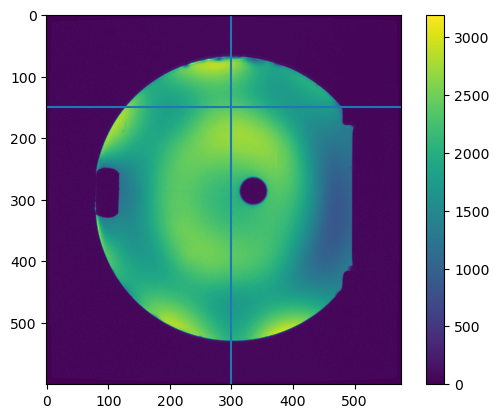

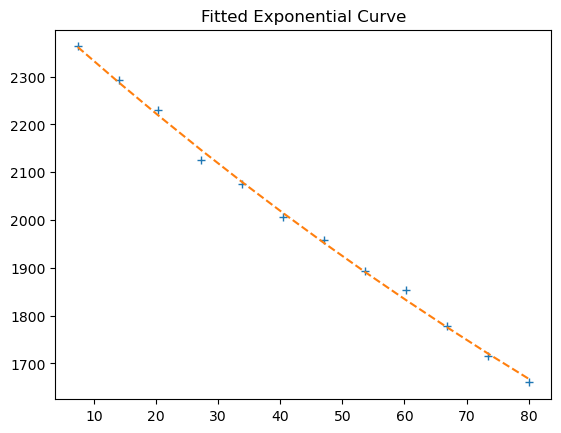

In [40]:
T2_calcul(mag_12TE_nylon, x=300, y=150, z= 11)

In [33]:
# m,n,p = np.shape(mag_12TE_vertebrae[0])
# T2_star_map = np.zeros((m,n,p))
# rsquared_map = np.zeros((m,n,p))

# for i in tqdm.tqdm(range(m)):
#     for j in (range(n)):
#         for k in (range(p)):
#             if mag_12TE_vertebrae[0][i][j][k] > 750:
#                 T2_star_map[i][j][k], rsquared_map[i][j][k] = T2_calcul(mag_12TE = mag_12TE_vertebrae,y = i, x=j, z=k, plot_and_print=False)


In [32]:
# plt.figure(figsize=(15,5))
# plt.subplot(121)
# plt.imshow(T2_star_map[:,:,13], aspect="auto", vmin=8, vmax=15)
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(rsquared_map[:,:,13], aspect="auto", vmin=0.8)
# plt.colorbar()
